<a href="https://colab.research.google.com/github/whyrzky/DS-Portfolio-Projects/blob/main/Machine%20Learning%3A%20AB%20Testing%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Load Packages

In [ ]:
!pip install dalex
!pip install scikit-plot
!pip install shap
!pip install skope-rules
!pip install eli5
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import TTestPower, TTestIndPower, GofChisquarePower
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm

import scipy.stats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
import dalex as dx

import scikitplot as skplt

%matplotlib inline

# Load Dataset

In [ ]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/marketing_campaign_experiment/marketing-clean.csv")

In [ ]:
raw_data

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion
0,a100000040,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,1/18/18,House Ads,False,1
1,a100000041,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,2/22/18,House Ads,False,1
2,a100000042,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,3/9/18,House Ads,False,1
3,a100000043,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,2/18/18,House Ads,False,1
4,a100000044,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,3/3/18,House Ads,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,a100007286,1/17/18,Email,control,True,German,German,19-24 years,1/17/18,3/5/18,Email,False,1
573,a100007287,1/17/18,Email,control,True,German,German,24-30 years,1/17/18,2/14/18,Email,False,1
574,a100007288,1/17/18,Email,control,True,German,German,30-36 years,1/17/18,4/26/18,Email,False,1
575,a100007289,1/17/18,Email,control,True,German,German,36-45 years,1/17/18,1/27/18,Email,False,1


In [ ]:
#Change date into datetime type
raw_data['date_served'] = pd.to_datetime(raw_data['date_served'])
raw_data['date_subscribed'] = pd.to_datetime(raw_data['date_subscribed'])
raw_data['date_canceled'] = pd.to_datetime(raw_data['date_canceled'])
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              577 non-null    object        
 1   date_served          577 non-null    datetime64[ns]
 2   marketing_channel    577 non-null    object        
 3   variant              577 non-null    object        
 4   converted            577 non-null    bool          
 5   language_displayed   577 non-null    object        
 6   language_preferred   577 non-null    object        
 7   age_group            577 non-null    object        
 8   date_subscribed      577 non-null    datetime64[ns]
 9   date_canceled        577 non-null    datetime64[ns]
 10  subscribing_channel  577 non-null    object        
 11  is_retained          577 non-null    bool          
 12  conversion           577 non-null    int64         
dtypes: bool(2), datetime64[ns](3), int6

In [ ]:
# initialize t-test power analysis object
analysis = GofChisquarePower()

result = analysis.solve_power(
    0.05, 
    alpha = 0.05, #--> rule of thumb
    power = 0.8, #--> rule of thumb
    n_bins = 2
)

In [ ]:
# Calculate sample size
print('Sample Size: %.3f' % result)

Sample Size: 3139.544


From this analysis, we can conclude that at a minimum we need 3140 participants in each group (control & experiment)

# Data Inspection and Exploration


Check null values inside data

In [ ]:
raw_data

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion
0,a100000040,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-01-18,House Ads,False,1
1,a100000041,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-02-22,House Ads,False,1
2,a100000042,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,2018-03-09,House Ads,False,1
3,a100000043,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-02-18,House Ads,False,1
4,a100000044,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-03-03,House Ads,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,a100007286,2018-01-17,Email,control,True,German,German,19-24 years,2018-01-17,2018-03-05,Email,False,1
573,a100007287,2018-01-17,Email,control,True,German,German,24-30 years,2018-01-17,2018-02-14,Email,False,1
574,a100007288,2018-01-17,Email,control,True,German,German,30-36 years,2018-01-17,2018-04-26,Email,False,1
575,a100007289,2018-01-17,Email,control,True,German,German,36-45 years,2018-01-17,2018-01-27,Email,False,1


In [ ]:
raw_data.isna().sum()

user_id                0
date_served            0
marketing_channel      0
variant                0
converted              0
language_displayed     0
language_preferred     0
age_group              0
date_subscribed        0
date_canceled          0
subscribing_channel    0
is_retained            0
conversion             0
dtype: int64

In [ ]:
# Unique Value for Datatype Object Columns
empDfObj = pd.DataFrame(raw_data, columns=['marketing_channel', 'variant','language_displayed','language_preferred','age_group','subscribing_channel','is_retained'])
print("Contents of the Data: ")
print(empDfObj)

# Get a series object containing the count of unique elements
# in each column of dataframe
uniqueValues = empDfObj.nunique()
print('Count of unique value sin each column :')
print(uniqueValues)

# Unique Value for Datatype Object Columns
# Get unique elements in multiple columns
unique = pd.unique(raw_data[['marketing_channel', 'variant','language_displayed','language_preferred','age_group','subscribing_channel','is_retained']].values.ravel('k'))
print('Unique elements in object columns :')
print(unique)

Contents of the Data: 
    marketing_channel          variant language_displayed language_preferred  \
0           House Ads  personalization            English            English   
1           House Ads  personalization             Arabic             Arabic   
2           House Ads  personalization            English            English   
3           House Ads  personalization            English            English   
4           House Ads  personalization             Arabic             Arabic   
..                ...              ...                ...                ...   
572             Email          control             German             German   
573             Email          control             German             German   
574             Email          control             German             German   
575             Email          control             German             German   
576             Email          control             German             German   

       age_group

Check number of sample of each variant

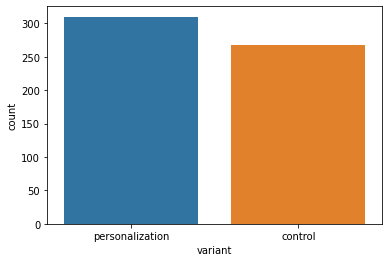

In [ ]:
sns.countplot(x = 'variant', data = raw_data)

Based on variant, the marketing team performs more marketing personalization than control marketing.

Check number of sample of each marketing channel

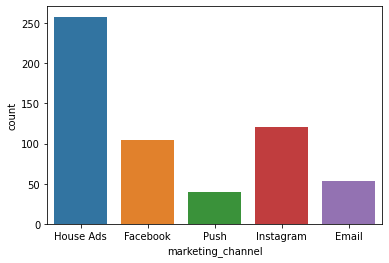

In [ ]:
sns.countplot(x = 'marketing_channel', data = raw_data)

Based on the data above, the largest user contribution coming from Ads comes from House Ads, followed by Instagram, Facebook, Email, and Push Notifications.

#A/B Testing

##User Convert Control vs Personalization

Text(0, 0.5, 'Variant (Value Counts)')

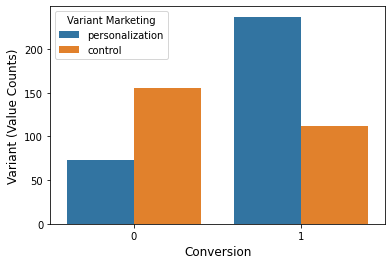

In [ ]:
# Target feature is 'Conversion' which means a convert is (1) and not convert is (0)
ax = sns.countplot(x='conversion', hue='variant', data=raw_data);

plt.legend(title='Variant Marketing', loc='upper left')
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Conversion", fontsize=12)
plt.ylabel("Variant (Value Counts)", fontsize=12)

There is a significant difference between new ads and previous ads.

The number of conversions on personalized ads is higher than on control ads. And the number of converts on personalized ads is higher than those that don't convert. However, the number of conversions in control ads is actually less than those that don't convert. This proves that personalized advertising can lead to more conversions, so personalized advertising has a significant role to get converted user.

## Variant vs Converted

In [ ]:
def prop_agg(df, y, x):
  temp_df = df.groupby([y,x], as_index = False).size()
  temp_df['prop'] = temp_df['size'] / temp_df.groupby(y)['size'].transform('sum')
  return temp_df

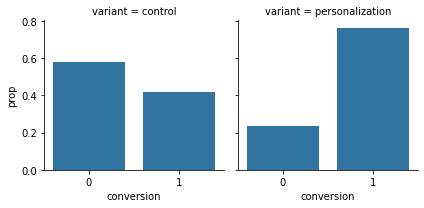

In [ ]:
g = sns.FacetGrid(
    data = prop_agg(raw_data, "variant", "conversion"),
    col = "variant"
)
g.map(sns.barplot, "conversion", "prop");

We can observe that total conversion of personalization marketing is greater than control marketing. It seems that there's significant effect of personalization compared to control, but need to prove it to statistical test.

## User Converted per Variant by The Time

In [ ]:
user_convert_timevariant = raw_data.assign(n_events = 0).groupby(['date_served','variant'], as_index=False).agg({'conversion': 'sum'}).sort_values(by=['date_served'], ascending=True).copy()
user_convert_timevariant

,date_served,variant,conversion
0,2018-01-01,control,0
1,2018-01-01,personalization,8
2,2018-01-02,control,0
3,2018-01-02,personalization,11
4,2018-01-03,control,1
...,...,...,...
56,2018-01-29,personalization,4
57,2018-01-30,control,2
58,2018-01-30,personalization,4
59,2018-01-31,control,1


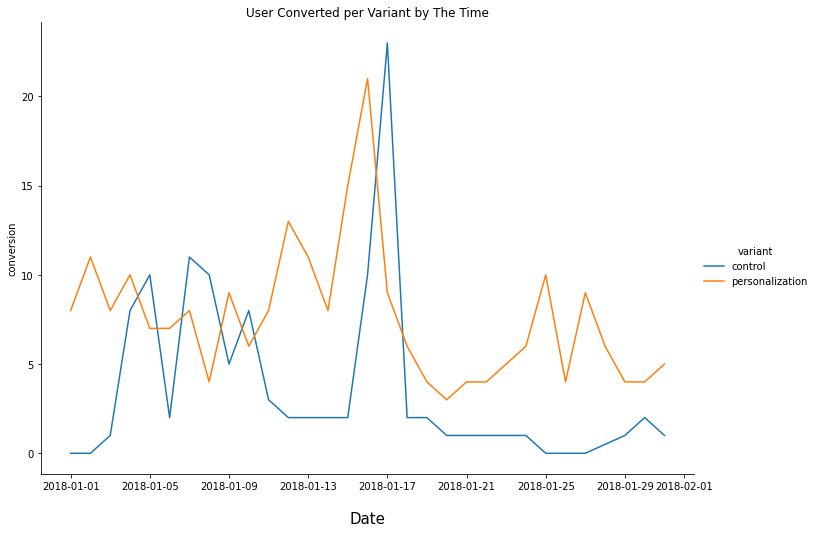

In [ ]:
ax = sns.relplot(x="date_served", y="conversion", hue="variant", kind="line", data=user_convert_timevariant, height=7, aspect=11.7/8.27);
ax.set(title = "User Converted per Variant by The Time");
plt.xticks(fontsize=10)
plt.xlabel('Date', fontsize=15, labelpad=20);

On a daily chart, personalized ads drive more conversions than control ads. High conversions were generated in the middle of the month for both personalized and control ads, followed by the 5-7th of January. Control ads are only suitable to be applied in the middle of the month and the 5-7th of January.

## User Converted per Variant by Age of Group

In [ ]:
user_convert_agevariant = raw_data.assign(n_events = 0).groupby(['age_group','variant'], as_index=False).agg({'conversion': 'sum'}).sort_values(by=['age_group'], ascending=True).copy()
user_convert_agevariant

,age_group,variant,conversion
0,0-18 years,control,16
1,0-18 years,personalization,50
2,19-24 years,control,15
3,19-24 years,personalization,80
4,24-30 years,control,14
5,24-30 years,personalization,64
6,30-36 years,control,14
7,30-36 years,personalization,11
8,36-45 years,control,19
9,36-45 years,personalization,10


Text(0.5, 20.80000000000002, 'Age Group')

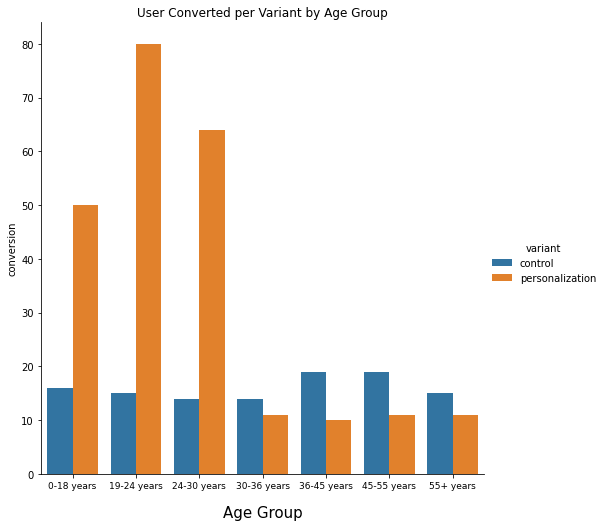

In [ ]:
ax = sns.catplot(x="age_group", y="conversion", hue="variant", kind="bar", data=user_convert_agevariant, height=7)
ax.set(title = "User Converted per Variant by Age Group");
plt.xticks(fontsize=9)
plt.xlabel('Age Group', fontsize=15, labelpad=15)

Personalized ads are very suitable to be applied to the age categories of 19-24 years, 24-30 years, and 0-18 years. This is presumably due the vulnerable age requires personalization value compared to the older age group. Therefore, marketing control is suitable to be applied to those aged more than 36 years.

## Using Proportion Test (Chi-Square) for Variant vs Conversion


Calculate conversion for each variant

In [ ]:
conv_calculation = raw_data.groupby(
    ['variant', 'conversion'], as_index = False
).size().pivot(
    index='variant', columns = "conversion", values = "size"
).reset_index().assign(
    conv_percent = lambda x: x[True] * 100 / (x[True] + x[False])
).assign(
    total_sample = lambda x: x[True] + x[False]
)

Check calculation result

In [ ]:
conv_calculation

conversion,variant,0,1,conv_percent,total_sample
0,control,155,112,41.947566,267
1,personalization,73,237,76.451613,310


Calculate uplift of B

In [ ]:
conv_control = conv_calculation[conv_calculation['variant'] == 'control']['conv_percent'].values
conv_personalization = conv_calculation[conv_calculation['variant'] == 'personalization']['conv_percent'].values

In [ ]:
(conv_personalization - conv_control)*100/conv_control

array([82.25518433])

We see there is 82,25% uplift of personalization compared to control

Do chi-squared test

In [ ]:
# find number of succession
success = conv_calculation[['total_sample', True]].values[:,1]
# find number of all observations
obs = conv_calculation[['total_sample', True]].values[:,0]

In [ ]:
result = proportions_chisquare(success, obs)

In [ ]:
# Calculate chi squared result
print('X-squared: %.3f' % result[0])
print('p-value: %.3f' % result[1])

X-squared: 71.454
p-value: 0.000


**Interpretation**

- Variant control has 112 conversions compared to variant personalization has 237
- Relative uplift of personalization from control around 82,25%
- p-value computed is 0.000 < 0.05, hence there is strong statistical significance in test results. Then, we should reject null hypothesis and proceed to launch variant personalization for all users


## Using Logistic Regression for Lenguange Preferred


We can use logistic regression when the value to compare is categorial.

In [ ]:
# select variant and converted columns
data_for_model = raw_data[['language_preferred', 'conversion']].copy()
# create dummy variables and remove first category
data_for_model = pd.get_dummies(data_for_model, drop_first = True)
# add constant
data_for_model = sm.add_constant(data_for_model)

In [ ]:
# check the first 5 rows
data_for_model.head()

,const,conversion,language_preferred_English,language_preferred_German,language_preferred_Spanish
0,1.0,1,1,0,0
1,1.0,1,0,0,0
2,1.0,1,1,0,0
3,1.0,1,1,0,0
4,1.0,1,0,0,0


In [ ]:
# define and fit logistic regression model
log_reg = sm.Logit(data_for_model['conversion'], data_for_model[['language_preferred_English','const']]).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.665128
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             conversion   No. Observations:                  577
Model:                          Logit   Df Residuals:                      575
Method:                           MLE   Df Model:                            1
Date:                Sun, 05 Jun 2022   Pseudo R-squ.:                0.008744
Time:                        17:12:18   Log-Likelihood:                -383.78
converged:                       True   LL-Null:                       -387.16
Covariance Type:            nonrobust   LLR p-value:                  0.009266
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
language_preferred_English    -0.7908      0.320     -2.475      0.013      -1.417      -0.165
const                          1.1451      0.307      3.732      0.000       0.544       1.747
==============================================================================================
"""

In [ ]:
# define and fit logistic regression model
log_reg = sm.Logit(data_for_model['conversion'], data_for_model[['language_preferred_German','const']]).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.660927
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             conversion   No. Observations:                  577
Model:                          Logit   Df Residuals:                      575
Method:                           MLE   Df Model:                            1
Date:                Sun, 05 Jun 2022   Pseudo R-squ.:                 0.01500
Time:                        17:12:18   Log-Likelihood:                -381.35
converged:                       True   LL-Null:                       -387.16
Covariance Type:            nonrobust   LLR p-value:                 0.0006531
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
language_preferred_German     1.9789      0.745      2.656      0.008       0.519       3.439
const                         0.3725      0.086      4.309      0.000       0.203       0.542
=============================================================================================
"""

In [ ]:
# define and fit logistic regression model
log_reg = sm.Logit(data_for_model['conversion'], data_for_model[['language_preferred_Spanish','const']]).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.670566
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             conversion   No. Observations:                  577
Model:                          Logit   Df Residuals:                      575
Method:                           MLE   Df Model:                            1
Date:                Sun, 05 Jun 2022   Pseudo R-squ.:               0.0006386
Time:                        17:12:18   Log-Likelihood:                -386.92
converged:                       True   LL-Null:                       -387.16
Covariance Type:            nonrobust   LLR p-value:                    0.4819
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
language_preferred_Spanish    -0.2847      0.403     -0.707      0.480      -1.074       0.505
const                          0.4389      0.087      5.029      0.000       0.268       0.610
==============================================================================================
"""

**Interpretation**

- We can observe uplift of variant B around 62.67%
- Based on p-value = 0.027 < alpha = 0.05, hence there is strong statistical significance in test results. Then, we should reject null hypothesis and proceed to launch variant B for all users

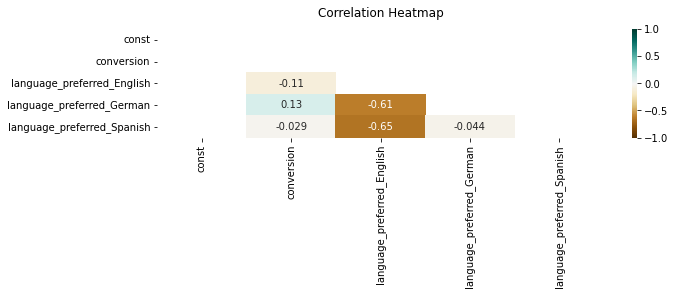

In [ ]:
# Increase the size of the heatmap
plt.figure(figsize=(10, 2))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(data_for_model.corr(), dtype=np.bool))
heatmap = sns.heatmap(data_for_model.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Train-Test Split Data

In [ ]:
# Change Type Data to Numeric
df = raw_data.copy()
df['language_preferred'].replace(['English','Arabic','German','Spanish'],[0,1,2,3],inplace=True)
df_for_model = df[['language_preferred', 'conversion']]
df_for_model

,language_preferred,conversion
0,0,1
1,1,1
2,0,1
3,0,1
4,1,1
...,...,...
572,2,1
573,2,1
574,2,1
575,2,1


In [ ]:
# cretate predictor variables as X
X = df_for_model.drop(['conversion'], axis = 1)
# create target data as y
y = df_for_model['conversion']

In [ ]:
# import train and test split method from scikit-learn
from sklearn.model_selection import train_test_split

# split data to train and test data
# where 30% of churn_data are test data
# stratify data based on y varibales
# and freeze RNG with random_state = 1000
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.3,
    stratify = y, 
    random_state=1000
)

In [ ]:
# check train data dimension
X_train.shape

(403, 1)

In [ ]:
# check test data dimension
X_test.shape

(174, 1)

In [ ]:
# check train target counts
y_train.value_counts()

1    244
0    159
Name: conversion, dtype: int64

In [ ]:
# check test target counts
y_test.value_counts()

1    105
0     69
Name: conversion, dtype: int64

In [ ]:
# pull numerical column
var_name = X_train.select_dtypes(include = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

### Data Exploration

In [ ]:
X_train["conversion"] = y_train

In [ ]:
import plotly.express as px

# language_preferred counts exploration
language_preferred = raw_data['language_preferred'].value_counts()
fig = px.pie(language_preferred, 
             values = language_preferred.values, 
             names = language_preferred.index,
             title='language_preferred',
             color_discrete_sequence=px.colors.sequential.RdBu,
             labels=['Englsih (0)','Arabic (1)','German (2)','Spanish (3)'])
fig.update_traces(textposition='inside', textinfo='percent+label', 
                  marker = dict(line = dict(color = 'white', width = 2)))

fig.show()

Conversion: 
No (0) 
Yes (1) 


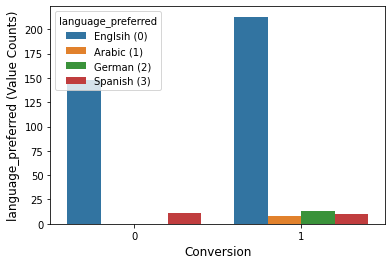

In [ ]:
# Target feature is 'Conversion' which means a convert is (1) and not convert is (0)
ax = sns.countplot(x='conversion', hue='language_preferred', data=X_train);

plt.legend(title='language_preferred', loc='upper left', labels=['Englsih (0)','Arabic (1)','German (2)','Spanish (3)'])
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel("Conversion", fontsize=12)
plt.ylabel("language_preferred (Value Counts)", fontsize=12)

print("Conversion: ")
print("No (0) ")
print("Yes (1) ");